In [1]:
# importações
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [2]:
# mapa de cores personalizado utilizado para alguns gráficos
custom_cmap = matplotlib.colors.ListedColormap(["#94d2bdff", "#72c3b4ff", "#4fb3aaff", "#2da3a0ff", "#0a9396ff", "#057985ff", "#005f73ff", "#004f5fff", "#003f4bff", "#002932ff"])

pallete: https://coolors.co/94d2bd-72c3b4-4fb3aa-2da3a0-0a9396-057985-005f73-004f5f-003f4b-002932

In [4]:
#funções utilizadas
def removePositions():
  global positions, positionsLabelsHistoric

  # subtrair arrays
  for a in positionsLabelsHistoric: 
    if a in positions: 
      positions.remove(a)

def addPositions():
  for a in positionsLabelsHistoric: 
    if a in positions: 
      positions.append(a)

def NewPositionSameLabel():
  global positions, positionsLabelsHistoric
  
  # transformando as posições da label que estao em tupla para lista
  positions = positionsCurrentCopyYTest[0].tolist()

  # subtrair arrays
  removePositions()

def newPredictionNewLabel():
  global newYtest, lock, formerLabel, labels, currentRandomLabel, positionsCurrentCopyYTest, positions, newPositionLabel, positionsLabelsHistoric, formerPrediction, currentPrediction, FP, TN

  positionsCurrentCopyYTest = np.where(copyY_test == currentRandomLabel)

  positions = positionsCurrentCopyYTest[0].tolist()

  addPositions()

  newPositionLabel = random.choice(positions)

  formerPrediction = currentPrediction

  currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
  if currentPrediction == formerPrediction:
    FP = FP + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
    newYtest.append(1)
  else:
    TN = TN + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
    newYtest.append(1)
    
  labels.append(formerLabel)

def newPredictionSameLabel():
  global newYtest, lock, formerLabel, labels, currentRandomLabel, positionsCurrentCopyYTest, positions, newPositionLabel, positionsLabelsHistoric, formerPrediction, currentPrediction, TP, FN

  positionsCurrentCopyYTest = np.where(copyY_test == currentRandomLabel)

  positions = positionsCurrentCopyYTest[0].tolist()

  addPositions()

  newPositionLabel = random.choice(positions)

  formerPrediction = currentPrediction

  currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
  if currentPrediction == formerPrediction:
    TP = TP + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
    newYtest.append(0)
  else:
    FN = FN + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
    newYtest.append(0)

def uniqueLabel():
  global positionsCurrentCopyYTest, positions, positionsLabelsHistoric, newPositionLabel, formerPrediction, currentPrediction, FP, TN, TP, FN
  
  positionsCurrentCopyYTest = np.where(copyY_test == labels[0])

  positions = positionsCurrentCopyYTest[0].tolist()

  # subtrair arrays
  removePositions()

  newPositionLabel = random.choice(positions)
  positionsLabelsHistoric.append(newPositionLabel)

  formerPrediction = currentPrediction

  currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
  if currentPrediction == formerPrediction:
    FP = FP + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
  else:
    TN = TN + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])


  for positionLabel in positions:
    formerPrediction = currentPrediction

    currentPrediction = knn.predict(copyX_test[positionLabel].reshape(1, -1))
    if currentPrediction == formerPrediction:
      TP = TP + 1
      trues.append(formerPrediction[0])
      predictions.append(currentPrediction[0])
    else:
      FN = FN + 1
      trues.append(formerPrediction[0])
      predictions.append(currentPrediction[0])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=custom_cmap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# obtendo os parametros para multi-classe
def perf_measure(y_actual, y_hat):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

In [5]:
# dataframe
df = pd.read_csv("https://raw.githubusercontent.com/zhangzhao156/Human-Activity-Recognition-Codes-Datasets/master/data/SanitationDataset/sanitation.csv")

In [6]:
df

,x,y,z,label,seg,suspicious
0,20,781,-507,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
1,40,797,-492,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
2,59,807,-502,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
3,75,807,-527,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
4,107,806,-560,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
...,...,...,...,...,...,...
266550,-941,174,337,clean,clean/庆喜/repeat_82-duration_60.csv-1584-1628,False
266551,-942,173,314,clean,clean/庆喜/repeat_82-duration_60.csv-1584-1628,False
266552,-916,158,310,clean,clean/庆喜/repeat_82-duration_60.csv-1584-1628,False
266553,-898,145,304,clean,clean/庆喜/repeat_82-duration_60.csv-1584-1628,False


In [7]:
# armazenando os valores de label
labelsName = df["label"].unique()

In [8]:
# dataframe que ira armazenar os valores das features dos calculadas
df_trat = pd.DataFrame()

In [9]:
# tempo de execução médio do código: 9 minutos
# for de iteração de cada label do dataframe
for lb in range(0, len(labelsName)):
  # tratando os dados: separando as linhas de cada label, split do ultimo numero da janela, retirando a coluna antiga da janela e inserindo a nova, armazenando os valores de cada janela
  dfSplited = df[df["label"] == labelsName[lb]]
  lastNDfSplited = dfSplited["seg"].squeeze()
  lastNDfSplited = lastNDfSplited.str.rsplit("-", n=1, expand=True)
  lastNDfSplited.rename(columns={0: 'seg', 1: 'random'}, inplace=True)
  dfSplited = dfSplited.drop(columns=['seg'])
  dfSplited = pd.concat([dfSplited, lastNDfSplited], axis=1)
  dfSplited = dfSplited[['x', 'y', 'z', 'label', 'seg', 'random', 'suspicious']]
  windowsDfSplited = dfSplited["random"].unique()

  cont = 0

  # for de iteração de cada janela de cada label do dataframe
  for window in range(len(df_trat), len(df_trat) + len(windowsDfSplited)):
    # calculando as features: maximo, minimo, binomial, media, mediana, variancia, desvp, mad
    df_trat.loc[window, 'maxX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.max()
    df_trat.loc[window, 'minX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.min()
    df_trat.loc[window, 'binX'] = (dfSplited[dfSplited.random == windowsDfSplited[cont]].x.max() - dfSplited[dfSplited.random == windowsDfSplited[cont]].x.min()) / 10
    df_trat.loc[window, 'medX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.mean()
    df_trat.loc[window, 'mediX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.median()
    df_trat.loc[window, 'varX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.var()
    df_trat.loc[window, 'desvX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.std()
    df_trat.loc[window, 'madX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.mad()

    df_trat.loc[window, 'maxY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.max()
    df_trat.loc[window, 'minY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.min()
    df_trat.loc[window, 'binnY'] = (dfSplited[dfSplited.random == windowsDfSplited[cont]].y.max() - dfSplited[dfSplited.random == windowsDfSplited[cont]].y.min()) / 10
    df_trat.loc[window, 'medY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.mean()
    df_trat.loc[window, 'mediY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.median()
    df_trat.loc[window, 'varY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.var()
    df_trat.loc[window, 'desvY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.std()
    df_trat.loc[window, 'madY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.mad()

    df_trat.loc[window, 'maxZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.max()
    df_trat.loc[window, 'minZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.min()
    df_trat.loc[window, 'binZ'] = (dfSplited[dfSplited.random == windowsDfSplited[cont]].z.max() - dfSplited[dfSplited.random == windowsDfSplited[cont]].z.min()) / 10
    df_trat.loc[window, 'medZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.mean()
    df_trat.loc[window, 'mediZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.median()
    df_trat.loc[window, 'varZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.var()
    df_trat.loc[window, 'desvZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.std()
    df_trat.loc[window, 'madZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.mad()

    cont+=1

df_trat

,maxX,minX,binX,medX,mediX,varX,desvX,madX,maxY,minY,...,desvY,madY,maxZ,minZ,binZ,medZ,mediZ,varZ,desvZ,madZ
0,143.0,-128.0,27.1,-42.970588,-77.0,6320.655838,79.502552,68.980104,896.0,696.0,...,41.808334,33.126298,-460.0,-691.0,23.1,-536.161765,-531.0,2895.421203,53.809118,43.117215
1,-88.0,-143.0,5.5,-109.395349,-105.0,246.339978,15.695221,13.482964,961.0,843.0,...,32.402183,28.484586,-159.0,-445.0,28.6,-312.511628,-322.0,8310.589147,91.162433,80.174148
2,15.0,-61.0,7.6,-24.238095,-30.0,319.795587,17.882829,15.204082,1006.0,951.0,...,12.633515,9.793651,-10.0,-134.0,12.4,-52.738095,-40.5,1344.783391,36.671288,31.379819
3,-59.0,-160.0,10.1,-120.176471,-128.0,559.550483,23.654819,20.008651,1016.0,851.0,...,36.453378,28.766003,-58.0,-455.0,39.7,-213.500000,-186.5,9542.522388,97.685835,83.250000
4,1053.0,-130.0,118.3,517.697674,631.0,215070.930233,463.757405,431.114116,772.0,77.0,...,170.741533,139.366144,137.0,-835.0,97.2,-473.325581,-577.0,94687.796235,307.713822,269.156301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,737.0,621.0,11.6,681.467742,679.0,431.597303,20.774920,16.239854,371.0,271.0,...,24.780138,20.555671,729.0,619.0,11.0,673.370968,679.0,912.302750,30.204350,26.528616
4390,804.0,661.0,14.3,730.326531,734.0,1335.016156,36.537873,30.211579,421.0,288.0,...,40.599797,35.099542,700.0,518.0,18.2,599.265306,588.0,3028.698980,55.033617,46.202416
4391,1078.0,404.0,67.4,756.268293,763.0,23795.501220,154.257905,104.638905,428.0,-146.0,...,141.282868,112.424747,794.0,315.0,47.9,623.268293,646.0,10985.351220,104.811026,71.633551
4392,1126.0,581.0,54.5,771.577465,757.0,7817.676056,88.417623,47.450506,465.0,35.0,...,74.628971,50.536005,726.0,396.0,33.0,598.732394,611.0,4019.170221,63.396926,42.271771


In [10]:
df_trat

,maxX,minX,binX,medX,mediX,varX,desvX,madX,maxY,minY,...,desvY,madY,maxZ,minZ,binZ,medZ,mediZ,varZ,desvZ,madZ
0,143.0,-128.0,27.1,-42.970588,-77.0,6320.655838,79.502552,68.980104,896.0,696.0,...,41.808334,33.126298,-460.0,-691.0,23.1,-536.161765,-531.0,2895.421203,53.809118,43.117215
1,-88.0,-143.0,5.5,-109.395349,-105.0,246.339978,15.695221,13.482964,961.0,843.0,...,32.402183,28.484586,-159.0,-445.0,28.6,-312.511628,-322.0,8310.589147,91.162433,80.174148
2,15.0,-61.0,7.6,-24.238095,-30.0,319.795587,17.882829,15.204082,1006.0,951.0,...,12.633515,9.793651,-10.0,-134.0,12.4,-52.738095,-40.5,1344.783391,36.671288,31.379819
3,-59.0,-160.0,10.1,-120.176471,-128.0,559.550483,23.654819,20.008651,1016.0,851.0,...,36.453378,28.766003,-58.0,-455.0,39.7,-213.500000,-186.5,9542.522388,97.685835,83.250000
4,1053.0,-130.0,118.3,517.697674,631.0,215070.930233,463.757405,431.114116,772.0,77.0,...,170.741533,139.366144,137.0,-835.0,97.2,-473.325581,-577.0,94687.796235,307.713822,269.156301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,737.0,621.0,11.6,681.467742,679.0,431.597303,20.774920,16.239854,371.0,271.0,...,24.780138,20.555671,729.0,619.0,11.0,673.370968,679.0,912.302750,30.204350,26.528616
4390,804.0,661.0,14.3,730.326531,734.0,1335.016156,36.537873,30.211579,421.0,288.0,...,40.599797,35.099542,700.0,518.0,18.2,599.265306,588.0,3028.698980,55.033617,46.202416
4391,1078.0,404.0,67.4,756.268293,763.0,23795.501220,154.257905,104.638905,428.0,-146.0,...,141.282868,112.424747,794.0,315.0,47.9,623.268293,646.0,10985.351220,104.811026,71.633551
4392,1126.0,581.0,54.5,771.577465,757.0,7817.676056,88.417623,47.450506,465.0,35.0,...,74.628971,50.536005,726.0,396.0,33.0,598.732394,611.0,4019.170221,63.396926,42.271771


In [11]:
# nomeando a coluna label com as respectivas labels das linhas do dataframe das features
df_trat.loc[0:170, 'label'] = 'walk'
df_trat.loc[171:1423, 'label'] = 'bweep' 
df_trat.loc[1424:2007, 'label'] = 'clean'
df_trat.loc[2008:2970, 'label'] = 'sweep' 
df_trat.loc[2971:3840, 'label'] = 'daily'
df_trat.loc[3841:4316, 'label'] = 'dump'
df_trat.loc[4317:4393, 'label'] = 'run'

In [12]:
# arredondando os valores das features
df_trat = df_trat.round(2)

bweep = 0
clean = 1
daily = 2
dump = 3
run = 4
sweep = 5
walk = 6

In [13]:
df_trat["label"] = df_trat["label"].astype('category')
df_trat["label"] = df_trat["label"].cat.codes

In [14]:
# embaralhando os dados
df_shuffled = df_trat.sample(frac=1).reset_index(drop=True)
df_shuffled

,maxX,minX,binX,medX,mediX,varX,desvX,madX,maxY,minY,...,madY,maxZ,minZ,binZ,medZ,mediZ,varZ,desvZ,madZ,label
0,680.0,-1204.0,188.4,-351.38,-402.5,306572.20,553.69,484.61,1642.0,563.0,...,302.61,1534.0,-920.0,245.4,3.30,-313.5,508059.16,712.78,597.06,1
1,1217.0,-674.0,189.1,20.93,-138.0,247239.42,497.23,394.04,1784.0,-1997.0,...,596.48,863.0,-1187.0,205.0,-462.12,-550.0,215557.91,464.28,317.33,0
2,1099.0,817.0,28.2,969.65,974.0,4688.70,68.47,54.29,975.0,-837.0,...,334.25,326.0,-523.0,84.9,-6.77,35.0,43023.54,207.42,159.10,1
3,180.0,-661.0,84.1,-266.18,-313.0,59775.59,244.49,209.21,333.0,-789.0,...,232.43,1482.0,89.0,139.3,898.86,927.0,184590.12,429.64,377.32,1
4,1562.0,623.0,93.9,1181.69,1210.0,37086.10,192.58,146.70,953.0,-275.0,...,174.65,103.0,-229.0,33.2,-15.82,-13.0,5696.35,75.47,60.33,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,-280.0,-1310.0,103.0,-853.35,-839.0,60237.31,245.43,183.93,857.0,17.0,...,164.70,664.0,-443.0,110.7,-41.41,-71.0,56653.95,238.02,179.92,5
4390,-175.0,-1463.0,128.8,-835.68,-825.0,77487.94,278.37,224.64,367.0,-838.0,...,220.20,1054.0,122.0,93.2,621.67,659.5,66706.20,258.28,216.97,5
4391,-229.0,-1591.0,136.2,-937.02,-939.0,121247.51,348.21,273.89,568.0,-147.0,...,144.91,532.0,-415.0,94.7,44.60,33.0,58671.10,242.22,200.35,5
4392,526.0,-543.0,106.9,102.79,171.0,82096.51,286.52,235.56,1389.0,255.0,...,228.91,87.0,-801.0,88.8,-360.47,-343.0,62436.22,249.87,214.71,0


In [15]:
df_input = df_shuffled.iloc[:,0:23]
df_output = df_shuffled.iloc[:,24]
X = df_input.values
Y = df_output.values

In [16]:
smt = SMOTE()

In [17]:
X, Y = smt.fit_resample(X, Y)

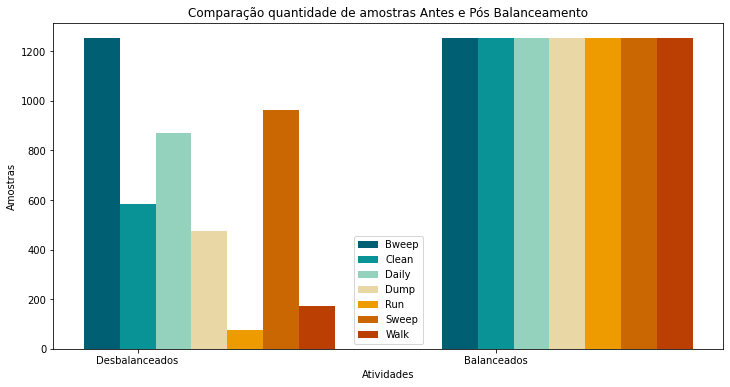

In [18]:
#Quantidades
qtd0 = [len(df_trat[df_trat["label"] == 0]), len(X[Y == 0])]
qtd1 = [len(df_trat[df_trat["label"] == 1]), len(X[Y == 1])]
qtd2 = [len(df_trat[df_trat["label"] == 2]), len(X[Y == 2])]
qtd3 = [len(df_trat[df_trat["label"] == 3]), len(X[Y == 3])]
qtd4 = [len(df_trat[df_trat["label"] == 4]), len(X[Y == 4])]
qtd5 = [len(df_trat[df_trat["label"] == 5]), len(X[Y == 5])]
qtd6 = [len(df_trat[df_trat["label"] == 6]), len(X[Y == 6])]

# Tamanho das barras
barWidth = 0.1

# Tamanho da figura
plt.figure(figsize=(12,6))

# Posição das barras
r0 = np.arange(len(qtd0))
r1 = [x + barWidth for x in r0]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

# Criando as barras
plt.bar(r0, qtd0, color="#005f73", width=barWidth, label="Bweep")
plt.bar(r1, qtd1, color="#0a9396", width=barWidth, label="Clean")
plt.bar(r2, qtd2, color="#94d2bd", width=barWidth, label="Daily")
plt.bar(r3, qtd3, color="#e9d8a6", width=barWidth, label="Dump")
plt.bar(r4, qtd4, color="#ee9b00", width=barWidth, label="Run")
plt.bar(r5, qtd5, color="#ca6702", width=barWidth, label="Sweep")
plt.bar(r6, qtd6, color="#bb3e03", width=barWidth, label="Walk")

# Adicionando legenda as barras
plt.xlabel('Atividades')
plt.xticks([r + barWidth for r in range(len(qtd0))], ['Desbalanceados', 'Balanceados'])
plt.ylabel('Amostras')
plt.title('Comparação quantidade de amostras Antes e Pós Balanceamento')

# Legenda e exibindo o gráfico
plt.legend()
plt.show()

pallet: https://coolors.co/001219-005f73-0a9396-94d2bd-e9d8a6-ee9b00-ca6702-bb3e03-ae2012-9b2226

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=5)

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
labels = df_shuffled["label"].unique()

In [22]:
labelsName.sort()
labels.sort()

# KNN

## Teste do algoritmo

In [23]:
knn = KNeighborsClassifier(n_neighbors=4)

In [24]:
# treinando o modelo
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [25]:
# predição dos valores do conjunto de teste
y_pred = knn.predict(X_test)

In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("Precision Test:",metrics.precision_score(y_test,y_pred))
# print("Recall Test:",metrics.recall_score(y_test,y_pred))

Accuracy: 0.9175531914893617


In [27]:
f1_score(y_test, y_pred, average='weighted') 

0.9172797151274898

In [28]:
labels = df_shuffled["label"].unique()

In [29]:
labelsName.sort()
labels.sort()

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       390
           1       0.93      0.91      0.92       381
           2       0.93      0.91      0.92       399
           3       0.88      0.90      0.89       361
           4       0.98      0.99      0.99       377
           5       0.90      0.91      0.90       358
           6       0.94      0.97      0.96       366

    accuracy                           0.92      2632
   macro avg       0.92      0.92      0.92      2632
weighted avg       0.92      0.92      0.92      2632

Confusion matrix, without normalization
[[326  13   9  16   0  23   3]
 [ 15 346   4  11   2   2   1]
 [  9   8 362   9   4   3   4]
 [ 14   4   4 326   0   8   5]
 [  0   1   0   0 374   0   2]
 [ 13   1   3   8   0 325   8]
 [  0   0   8   0   2   0 356]]


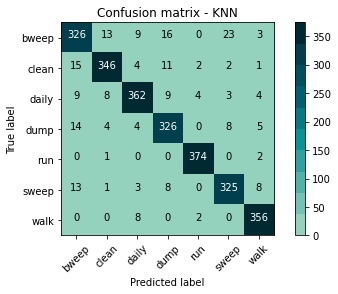

In [30]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=labels.tolist())
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelsName.tolist(),normalize= False,  title='Confusion matrix - KNN')

In [31]:
teste = perf_measure(y_test, y_pred)

In [32]:
teste

({0, 1, 2, 3, 4, 5, 6},
 [326, 346, 362, 326, 374, 325, 356],
 [51, 27, 28, 44, 8, 36, 23],
 [2089, 2069, 2053, 2089, 2041, 2090, 2059],
 [166, 190, 189, 173, 209, 181, 194])

In [33]:
print(teste[2])
print(teste[4])

[51, 27, 28, 44, 8, 36, 23]
[166, 190, 189, 173, 209, 181, 194]


In [34]:
fp = int(sum(teste[2])/7)
fn = int(sum(teste[4])/7)


print(fp)
print(fn)

31
186


In [35]:
accuracys = []

# Calculating error for K values between 1 and 10
for i in range(1, 10):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    accuracys.append(metrics.accuracy_score(y_test, pred_i))

In [36]:
accuracys

[0.9297112462006079,
 0.9266717325227963,
 0.9190729483282675,
 0.9175531914893617,
 0.9042553191489362,
 0.9038753799392097,
 0.901595744680851,
 0.901595744680851,
 0.895516717325228]

Text(0, 0.5, 'Accuracy')

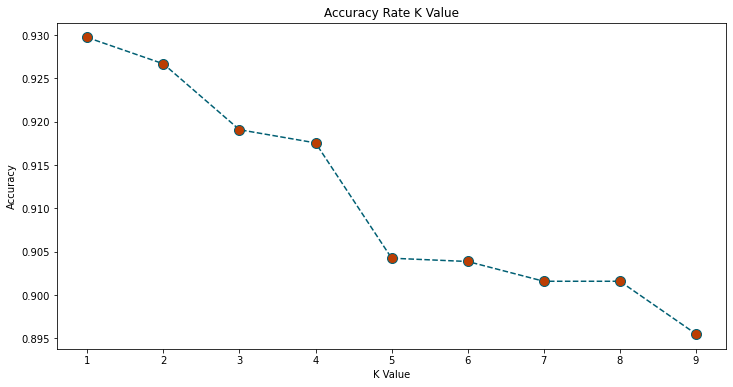

In [37]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 10), accuracys, color='#005f73', linestyle='dashed', marker='o',  
         markerfacecolor='#bb3e03', markersize=10)
plt.title('Accuracy Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy')

In [38]:
# validação cruzada
num_folds = 5
scores = cross_val_score(knn, X_train, y_train, cv = num_folds)

In [39]:
scores

array([0.9 , 0.89, 0.9 , 0.9 , 0.9 ])

In [40]:
for v in scores:
  print(v)

0.8998371335504886
0.8949511400651465
0.8998371335504886
0.9030944625407166
0.8973105134474327


In [41]:
stdevCross = scores.std()
stdevCross

0.002735458119445182

## Avaliação mudança de atividade

1. Escolher uma amostra de um tipo de atividade qualquer e rodar a avaliação do algoritmo.

2. Sortear um numero com probabilidade de 10% para um numero e 90% para outra, caso caia nos 10% escolher uma outra amostra de uma atividade diferente, do contrário escolher outra amostra com a mesma atividade.

3. Rodar a avaliação do algoritmo.

4. Repetir os passos com o restante das amostras.

5. Ao final, analizar as métricas.

> Sequencia de uma atividade - >= 0.005 (99,95%)

- Algoritmo identificar como atividade diferente (mudança de atividade para o algoritmo) marcar como FN
- Algoritmo identificar como mesma atividade (não mudança de atividade para o algoritmo) marcar como TP

> Mudança de atividade - < 0.005 (0,05%)

- Algoritmo identificar como atividade diferente (mudança de atividade para o algoritmo) marcar como TN
- Algoritmo identificar como mesma atividade (não mudança de atividade para o algoritmo) marcar como FP


In [42]:
copyX_test = X_test
copyY_test = y_test

### 1. Probabilidade única

In [43]:
accuracys = []

FPs = []
FNs = []
TPs = []
TNs = []

trues = []
predictions = []

for i in np.arange(0, 10):
  labels = df_shuffled["label"].unique().tolist()

  TP = 0
  TN = 0
  FP = 0
  FN = 0

  newYtest = []

  formerLabel = 0
  formerPrediction = 0

  lock = 0

  initialRandomLabel = random.choice(labels) # Label aleatória inicial

  positionsInitialCopyYTest = np.where(copyY_test == initialRandomLabel) # Todas as posições em que a label inicial aparece
  positionsCurrentCopyYTest = positionsInitialCopyYTest

  initialPositionLabel = copyY_test[random.choice(positionsInitialCopyYTest[0])] # Posição aleatória em que a label inicial aparece, essa posição tambem valera para a primeira amostra
  currentRandomLabel = initialRandomLabel # label atual, no inicio da analise a label inicial é a label atual 

  positionsLabelsHistoric = []


  initialPrediction = knn.predict(copyX_test[initialPositionLabel].reshape(1, -1)) # predição da linha inicial da analise
  currentPrediction = initialPrediction

  positionsLabelsHistoric.append(initialPositionLabel)

  random.seed(random.randint(1, 10000))
  # loop da analise que ira iterar cada amostra do conjunto de amostras
  while True:
    if (FP + TP + TN + FN) == len(copyX_test) * 10:
      break
    else:
      randomNumber = random.random()

      # Analisando nova amostra da mesma atividade 
      if randomNumber >= 0.005:
        NewPositionSameLabel()

        if positions == []:
          newPredictionSameLabel()
        else:
          newPositionLabel = random.choice(positions)
          positionsLabelsHistoric.append(newPositionLabel)

          formerPrediction = currentPrediction

          currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
          if currentPrediction == formerPrediction:
            TP = TP + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(0)
          else:
            FN = FN + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(0)

      # Analise de uma nova amostra de atividade diferente
      if randomNumber < 0.005:
        # armazenando a antiga label e removendo a mesma temporariamente do array de labels
        formerLabel = currentRandomLabel
        labels.remove(formerLabel)

        # Randomizando uma nova label
        currentRandomLabel = random.choice(labels)
        # NDArray com as posições da nova label e randomização da posição aleatoria
        positionsCurrentCopyYTest = np.where(copyY_test == currentRandomLabel)

        NewPositionSameLabel()

        if positions == []:
          newPredictionNewLabel()
        else:
          newPositionLabel = random.choice(positions)
          positionsLabelsHistoric.append(newPositionLabel)

          formerPrediction = currentPrediction

          currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
          if currentPrediction == formerPrediction:
            FP = FP + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(1)
          else:
            TN = TN + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(1)

          # devolvendo a label antiga ao array de labels
          labels.append(formerLabel)

  accuracy = (TP + TN)/(TP + TN + FP + FN)
  accuracys.append(accuracy)
  FPs.append(FP)
  FNs.append(FN)
  TPs.append(TP)
  TNs.append(TN)

In [49]:
print(FPs)
print(FNs)
print(TPs)
print(TNs)

[4, 7, 1, 3, 2, 5, 6, 6, 2, 2]
[5335, 4874, 4661, 4781, 4657, 5200, 5469, 4731, 5125, 4336]
[20854, 21322, 21549, 21408, 21534, 20982, 20705, 21445, 21054, 21852]
[127, 117, 109, 128, 127, 133, 140, 138, 139, 130]


In [44]:
accuracys

[0.7971504559270517,
 0.8145516717325227,
 0.8228723404255319,
 0.8182370820668693,
 0.8229863221884498,
 0.8022416413373861,
 0.791983282674772,
 0.8200227963525836,
 0.8052051671732523,
 0.8351823708206687]

In [45]:
FinalAccuracy = sum(accuracys)/len(accuracys) # média das acuracias
FinalAccuracy

0.8130433130699087

In [46]:
labels = df_shuffled["label"].unique()
labels.sort()

              precision    recall  f1-score   support

           0       0.67      0.67      0.67     34374
           1       0.80      0.80      0.80     37795
           2       0.79      0.79      0.79     38922
           3       0.74      0.74      0.74     37166
           4       0.96      0.96      0.96     40312
           5       0.77      0.77      0.77     36283
           6       0.89      0.89      0.89     38348

    accuracy                           0.81    263200
   macro avg       0.80      0.80      0.80    263200
weighted avg       0.81      0.81      0.81    263200

Confusion matrix, without normalization
[[23130  2621  1926  2565   260  3468   404]
 [ 2652 30097  1755  2297   338   488   168]
 [ 1909  1755 30713  1408   474  1040  1623]
 [ 2571  2301  1384 27661   192  2299   758]
 [  249   346   476   188 38754    56   243]
 [ 3479   496  1065  2254    54 28086   849]
 [  386   180  1601   793   241   845 34302]]


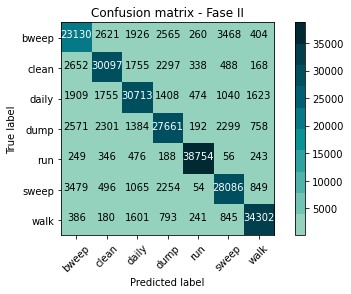

In [47]:
cnf_matrix = confusion_matrix(trues, predictions, labels=labels.tolist())
np.set_printoptions(precision=2)

print (classification_report(trues, predictions))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelsName.tolist(),normalize= False,  title='Confusion matrix - Fase II')

In [50]:
copyX_test = X_test
copyY_test = y_test

### 2. Variação das probabilidades

In [51]:
# tempo de execução médio do código: 5 minutos
accuracys = []
FPs = []
FNs = []

for i in np.arange(0.1, 1, 0.1):
  labels = df_shuffled["label"].unique().tolist()

  TP = 0
  TN = 0
  FP = 0
  FN = 0

  newYtest = []

  formerLabel = 0
  formerPrediction = 0

  lock = 0

  initialRandomLabel = random.choice(labels) # Label aleatória inicial

  positionsInitialCopyYTest = np.where(copyY_test == initialRandomLabel) # Todas as posições em que a label inicial aparece
  positionsCurrentCopyYTest = positionsInitialCopyYTest

  initialPositionLabel = copyY_test[random.choice(positionsInitialCopyYTest[0])] # Posição aleatória em que a label inicial aparece, essa posição tambem valera para a primeira amostra
  currentRandomLabel = initialRandomLabel # label atual, no inicio da analise a label inicial é a label atual 

  positionsLabelsHistoric = []


  initialPrediction = knn.predict(copyX_test[initialPositionLabel].reshape(1, -1)) # predição da linha inicial da analise
  currentPrediction = initialPrediction

  positionsLabelsHistoric.append(initialPositionLabel)

  random.seed(random.randint(1, 10000))
  # loop da analise que ira iterar cada amostra do conjunto de amostras
  while True:
    if (FP + TP + TN + FN) == len(copyX_test):
      break
    else:
      randomNumber = random.random()

      # Analisando nova amostra da mesma atividade 
      if randomNumber > i:
        NewPositionSameLabel()

        if positions == []:
          newPredictionSameLabel()
        else:
          newPositionLabel = random.choice(positions)
          positionsLabelsHistoric.append(newPositionLabel)

          formerPrediction = currentPrediction

          currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
          if currentPrediction == formerPrediction:
            TP = TP + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(0)
          else:
            FN = FN + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(0)

      # Analise de uma nova amostra de atividade diferente
      if randomNumber < i:
        # armazenando a antiga label e removendo a mesma temporariamente do array de labels
        formerLabel = currentRandomLabel
        labels.remove(formerLabel)

        # Randomizando uma nova label
        currentRandomLabel = random.choice(labels)
        # NDArray com as posições da nova label e randomização da posição aleatoria
        positionsCurrentCopyYTest = np.where(copyY_test == currentRandomLabel)

        NewPositionSameLabel()

        if positions == []:
          newPredictionNewLabel()
        else:
          newPositionLabel = random.choice(positions)
          positionsLabelsHistoric.append(newPositionLabel)

          formerPrediction = currentPrediction

          currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
          if currentPrediction == formerPrediction:
            FP = FP + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(1)
          else:
            TN = TN + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(1)

          # devolvendo a label antiga ao array de labels
          labels.append(formerLabel)

  accuracy = (TP + TN)/(TP + TN + FP + FN)
  accuracys.append(accuracy)
  FPs.append(FP)
  FNs.append(FN)

In [52]:
accuracys

[0.8111702127659575,
 0.8404255319148937,
 0.8704407294832827,
 0.868920972644377,
 0.8939969604863222,
 0.9065349544072948,
 0.9209726443768997,
 0.9380699088145896,
 0.9513677811550152]

Text(0, 0.5, 'FPs')

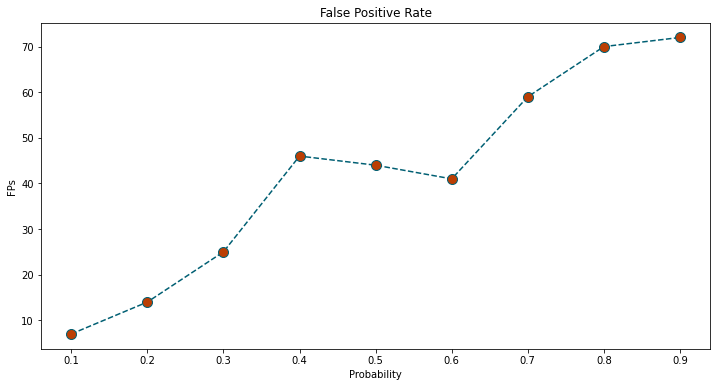

In [53]:
plt.figure(figsize=(12, 6))  
plt.plot(np.arange(0.1, 1, 0.1), FPs, color='#005f73', linestyle='dashed', marker='o',  
         markerfacecolor='#bb3e03', markersize=10)
plt.title('False Positive Rate')  
plt.xlabel('Probability')  
plt.ylabel('FPs') 

Text(0, 0.5, 'FNs')

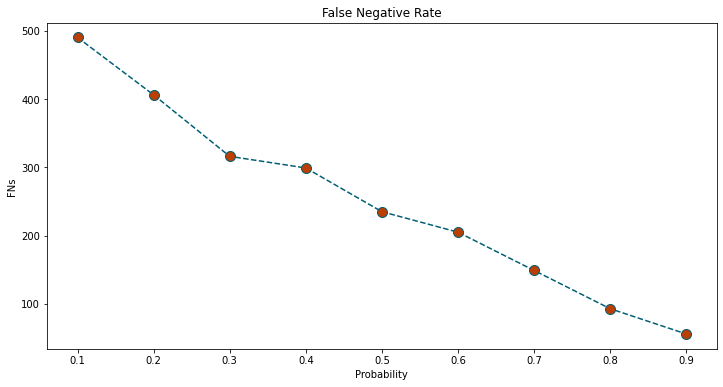

In [54]:
plt.figure(figsize=(12, 6))  
plt.plot(np.arange(0.1, 1, 0.1), FNs, color='#005f73', linestyle='dashed', marker='o',  
         markerfacecolor='#bb3e03', markersize=10)
plt.title('False Negative Rate')  
plt.xlabel('Probability')  
plt.ylabel('FNs') 

Text(0, 0.5, 'Accuracy')

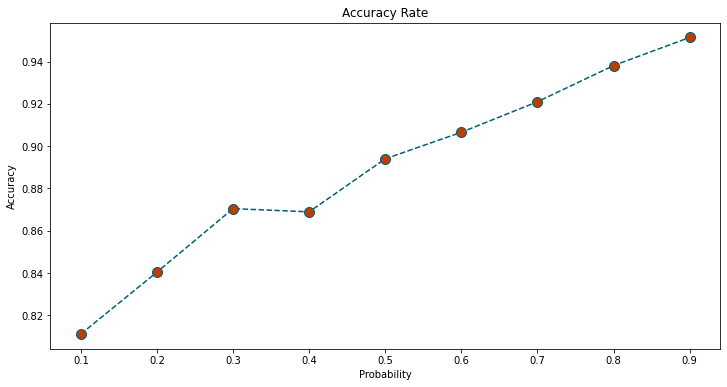

In [55]:
plt.figure(figsize=(12, 6))  
plt.plot(np.arange(0.1, 1, 0.1), accuracys, color='#005f73', linestyle='dashed', marker='o',  
         markerfacecolor='#bb3e03', markersize=10)
plt.title('Accuracy Rate')  
plt.xlabel('Probability')  
plt.ylabel('Accuracy') 

# Regressão Logistica

In [56]:
LR = LogisticRegression(solver='saga',multi_class='multinomial').fit(X_train,y_train)

c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [57]:
yhat = LR.predict(X_test)
yhat

array([5, 2, 4, ..., 5, 5, 4], dtype=int8)

In [58]:
f1_score(y_test, yhat, average='weighted') 

0.6786359045239028

In [59]:
print("Accuracy Test:",metrics.accuracy_score(y_test, yhat))
#print("Precision Test:",metrics.precision_score(y_test, yhat))

Accuracy Test: 0.685790273556231


In [60]:
y_proba = LR.predict_proba(X_test)

In [61]:
y_proba[0]

array([1.41e-01, 1.71e-02, 1.56e-02, 9.56e-02, 1.25e-04, 7.26e-01,
       4.85e-03])

In [62]:
labels = df_shuffled["label"].unique()
labels.sort()

              precision    recall  f1-score   support

           0       0.58      0.41      0.48       390
           1       0.60      0.51      0.56       381
           2       0.63      0.63      0.63       399
           3       0.71      0.68      0.70       361
           4       0.96      0.87      0.91       377
           5       0.68      0.84      0.75       358
           6       0.64      0.89      0.74       366

    accuracy                           0.69      2632
   macro avg       0.69      0.69      0.68      2632
weighted avg       0.69      0.69      0.68      2632

Confusion matrix, without normalization
[[158  45  36  23   2  92  34]
 [ 34 196  51  67   0  14  19]
 [ 22  55 252   2   7   6  55]
 [ 19  17  13 247   0  23  42]
 [  1   2  21   3 328   0  22]
 [ 30   8   2   5   0 300  13]
 [  7   1  23   2   6   3 324]]


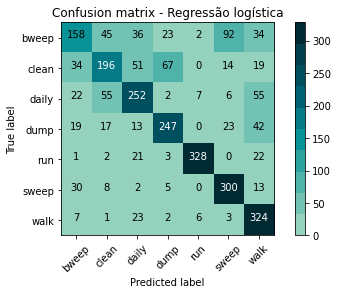

In [63]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=labels.tolist())
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelsName.tolist(),normalize= False,  title='Confusion matrix - Regressão logística')

In [64]:
num_folds = 5
scores = cross_val_score(LR, X_train, y_train, cv = num_folds)

c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

In [65]:
scores

array([0.68, 0.69, 0.69, 0.69, 0.71])

In [66]:
for v in scores:
  print(v)

0.6758957654723127
0.6864820846905537
0.6864820846905537
0.6905537459283387
0.7057864710676447


In [67]:
stdevCross = scores.std()
stdevCross

0.009680831397456091

#SVM

In [68]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [69]:
yhat = clf.predict(X_test)
yhat 

array([5, 2, 4, ..., 1, 5, 4], dtype=int8)

In [70]:
f1_score(y_test, yhat, average='weighted') 

0.8701819361734021

In [71]:
print("Accuracy:",metrics.accuracy_score(y_test, yhat))

Accuracy: 0.8712006079027356


              precision    recall  f1-score   support

           0       0.85      0.71      0.78       390
           1       0.89      0.89      0.89       381
           2       0.88      0.87      0.88       399
           3       0.85      0.84      0.85       361
           4       0.98      0.95      0.96       377
           5       0.83      0.89      0.86       358
           6       0.81      0.95      0.88       366

    accuracy                           0.87      2632
   macro avg       0.87      0.87      0.87      2632
weighted avg       0.87      0.87      0.87      2632

Confusion matrix, without normalization
[[277  24  15  14   1  38  21]
 [ 10 340  10  13   1   6   1]
 [ 14   9 348   7   4   4  13]
 [  5   3   7 304   0  14  28]
 [  1   2   0   6 358   0  10]
 [ 17   3   3  11   0 318   6]
 [  0   0  13   2   1   2 348]]


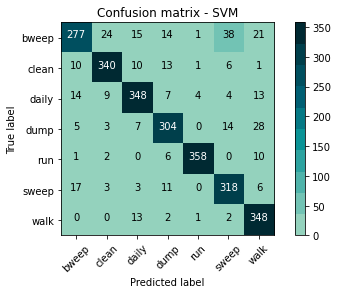

In [72]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=labels.tolist())
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelsName.tolist(),normalize= False,  title='Confusion matrix - SVM')

In [73]:
num_folds = 5
scores = cross_val_score(clf, X_train, y_train, cv = num_folds)

In [74]:
scores

array([0.87, 0.87, 0.86, 0.88, 0.88])

In [75]:
for v in scores:
  print(v)

0.8745928338762216
0.8737785016286646
0.8615635179153095
0.8786644951140065
0.876120619396903


In [76]:
stdevCross = scores.std()
stdevCross

0.00592866584893309

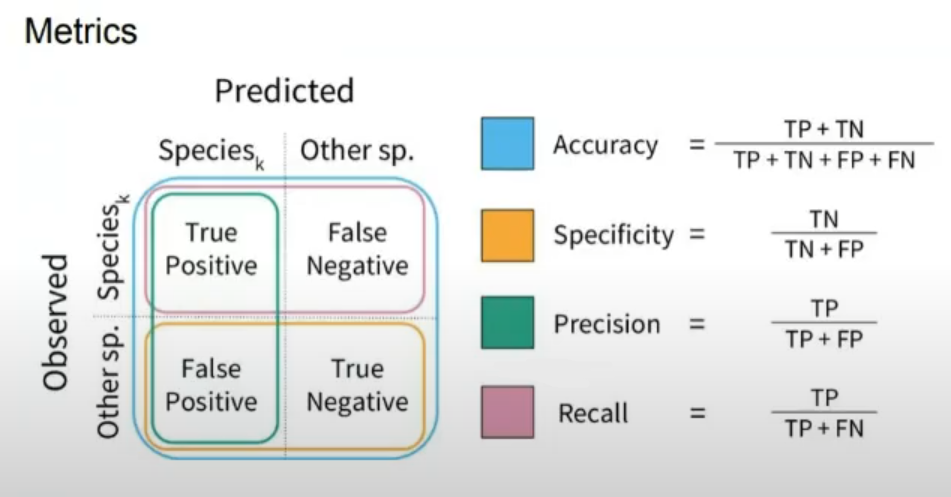